# Classify time series / single measurement into "improve", "same", and "worse" after 3 and 12 months

In [1]:
import sys
sys.path.append('../')
import importlib
import estimators
import datasets
importlib.reload(estimators)
importlib.reload(datasets)
from estimators import Estimator, merged_config, plot_history, plot_history_comparison
import models
import losses
from copy import deepcopy
from datasets import IOVar, LongitudinalOCTDataset
from sequences import load_sequences_from_pickle, Measurement
import matplotlib.pyplot as plt
import logging
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, f1_score
plt.rcParams['figure.facecolor'] = 'white'

logging.basicConfig(level=logging.INFO) # need one of this?
logging.getLogger().setLevel(logging.INFO) # need one of this?

In [2]:
# load data
workspace_dir = '../../workspace' #'/storage/groups/ml01/workspace/hannah.spitzer/LODE'
fig_dir = 'figures'
features_file = '../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv'
sequences_file = os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle')
sequences_all = load_sequences_from_pickle(sequences_file)
features_csv = pd.read_csv(features_file, index_col=0)
features_csv.columns = ['background','epiretinal_membrane','vitrous','camera_effect','neurosensory_retina','intraretinal_fluid','subretinal_fluid','subretinal_hyper_reflective_material','RPE','fibrovascular_PED','dusenoid_PED','posterios_hylaois_membrane','dicom_name','frame','patient_id','oct_path','laterality','study_date']
features_csv.study_date = pd.to_datetime(features_csv.study_date)

/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
default_config = {
    'sequence_data': {
        'load_sequences': True,
        'sequences_fname': sequences_file,
        'features_fname': features_file,
        'num_checkups': 2,
    },
    'sequence_split': {
        'min_len': 3,
        'max_len': None,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': models.SimpleANNModel,
        'input_vars': [IOVar.CUR_VA, IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES],
        'output_vars': [IOVar.CHECKUP2_DIFF_VA_CLASS],
        'norm': [None, None, None, None, None],
        'sequence_length': 1,
        'num_dataloaders': 3,
        'model_kwargs': {
            'encoder_layers': {'num_layers':0},
            'dense_layers': {'num_layers': 2},
            'decoder_layers': {'num_layers': 0},
            'output_layer': {'units': 3, 'activation':'softmax'}
        },
        'oversample_classification': True,
    },
    'training': {
        'loss': losses.categorical_crossentropy_last,
        'metrics': [losses.categorical_accuracy_last, 
                    losses.PrecisionLast(class_id=0, name='precision_cl0'), 
                    losses.RecallLast(class_id=0, name='recall_cl0'),
                    losses.PrecisionLast(class_id=1, name='precision_cl1'), 
                    losses.RecallLast(class_id=1, name='recall_cl1'),
                    losses.PrecisionLast(class_id=2, name='precision_cl2'), 
                    losses.RecallLast(class_id=2, name='recall_cl2'),
                   ],
        'batch_size': 512,
        'epochs': 15,
        'learning_rate': 0.01,
    }
}

## Analyze relationships between features and logMAR
### Plot features vs classes

In [4]:
est = Estimator(default_config)

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:13<00:00, 453.63it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_DIFF_VA_CLASS: 'checkup2_diff_va_class'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 3,
        "activation": "softmax",
        "log": false
    }
}


In [11]:
classes = np.argmax(est.val_dataset.get_value_list([IOVar.CHECKUP2_DIFF_VA_CLASS])[0], axis=-1)[:,-1]
print('same:', (classes==2).sum()/len(classes))
print('impr:', (classes==0).sum()/len(classes))
print('worse:', (classes==1).sum()/len(classes))

same: 0.6
impr: 0.14455445544554454
worse: 0.25544554455445545


In [9]:
io_vars = (IOVar.ALL_FEATURES, IOVar.CUR_VA, IOVar.CHECKUP2_ALL_FEATURES, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS)
dataset = LongitudinalOCTDataset(est.sequences_all, sequence_length=1, return_values=io_vars)

In [24]:
features = []
vas = []
checkup_features = []
checkup_vas = []
labels = []

for feature, va, checkup_feature, checkup_va, label in dataset.dataset:
    features.append(feature.numpy()[0])
    checkup_features.append(checkup_feature.numpy()[0])
    vas.append(va.numpy()[0])
    checkup_vas.append(checkup_va.numpy()[0])
    labels.append(np.argmax(label.numpy()[0]))
features = np.array(features)
labels = np.array(labels)
checkup_features = np.array(checkup_features)
vas = np.array(vas)
checkup_vas = np.array(checkup_vas)

features_norm = (features - features.mean(axis=0)) / features.std(axis=0)
checkup_features_norm = (checkup_features - checkup_features.mean(axis=0)) / checkup_features.std(axis=0)

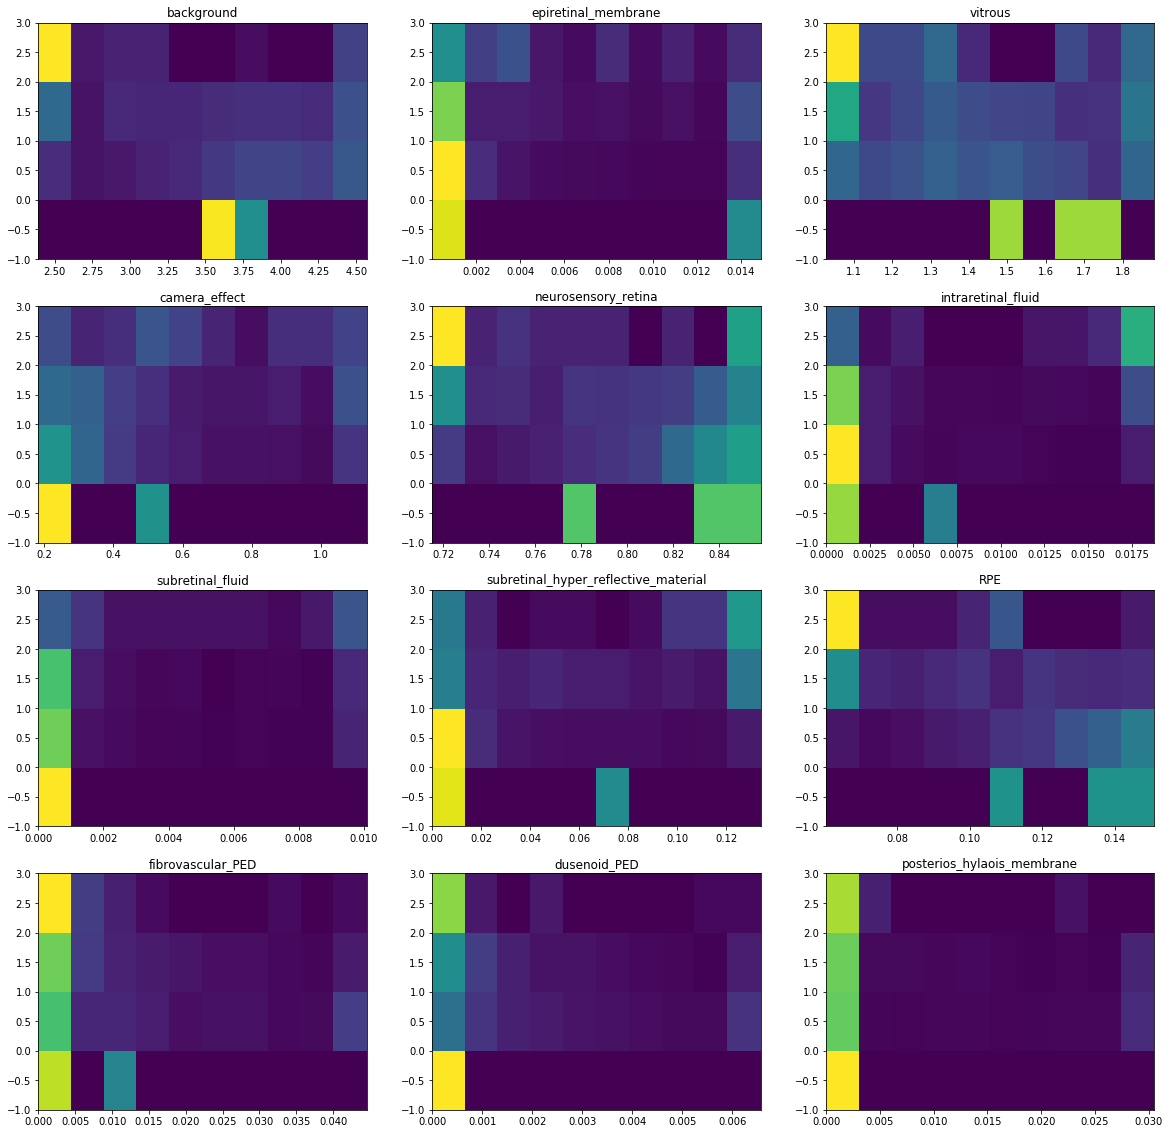

In [11]:
# plot checkup va vs checkup features
# only plot for those records that have a big change in va
mask = labels != 2  # mask = np.ones_like(labels)
fig, axes = plt.subplots(4,3, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    # restrict features to 0.1 and 0.9 quantile
    q01, q09 = np.quantile(checkup_features[mask][:,i], (0.1,0.9))
    feat = checkup_features[mask][:,i].copy()
    feat[feat < q01] = q01
    feat[feat > q09] = q09
    data, binx, biny = np.histogram2d(feat, checkup_vas[mask][:,0], bins=(10,[-1,0,1,2,3]))
    #data, binx, biny = np.histogram2d(feat, checkup_vas[mask][:,0], bins=(10,np.arange(0,2,0.1)))
    # normalize by va
    data = data / data.sum(axis=0, keepdims=True)
    #data = data/ data.sum(axis=1, keepdims=True)
    ax.pcolormesh(binx, biny, data.T)
    ax.set_title(Measurement.FEATURES[i])


can see effect of RPE but not much more

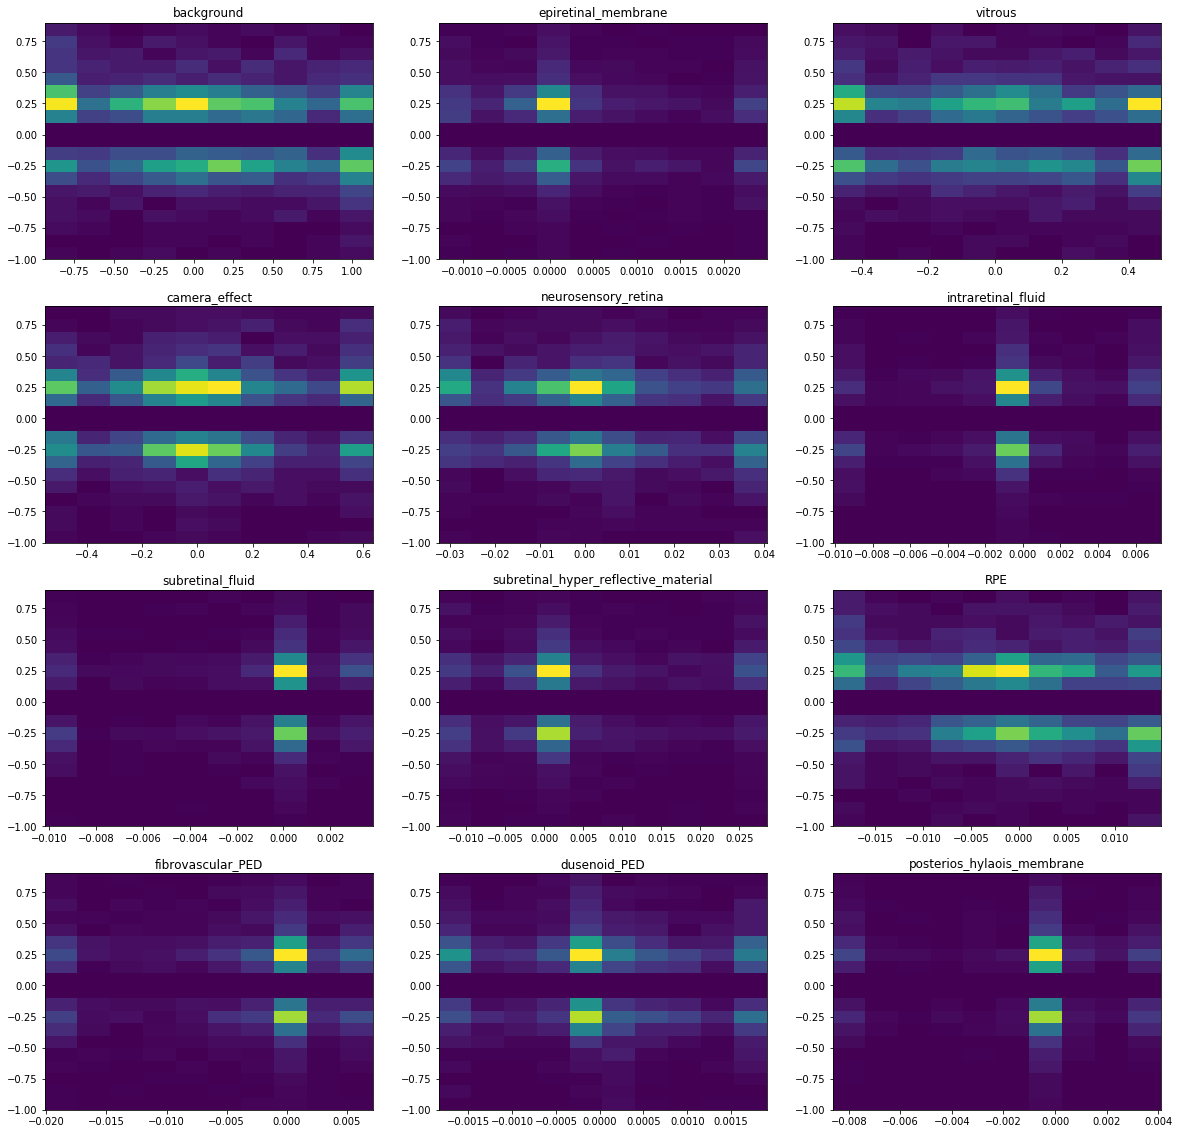

In [12]:
# plot diff in features vs diff in va
# only plot for those records that have a big change in va
mask = labels != 2  # mask = np.ones_like(labels)
diff_features = checkup_features - features
diff_va = checkup_vas - vas

fig, axes = plt.subplots(4,3, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    # restrict features to 0.1 and 0.9 quantile
    q01, q09 = np.quantile(diff_features[mask][:,i], (0.1,0.9))
    feat = diff_features[mask][:,i].copy()
    feat[feat < q01] = q01
    feat[feat > q09] = q09
    # data histogram
    data, binx, biny = np.histogram2d(feat, diff_va[mask][:,0], bins=(10,np.arange(-1,1,0.1)))
    #data, binx, biny = np.histogram2d(feat, checkup_vas[mask][:,0], bins=(10,np.arange(0,2,0.1)))
    # normalize by va
    #data = data / data.sum(axis=0, keepdims=True)
    #data = data/ data.sum(axis=1, keepdims=True)
    ax.pcolormesh(binx, biny, data.T)
    ax.set_title(Measurement.FEATURES[i])

difference in single feature volumes does not seem to be correlated to difference in va (even large differences in va)

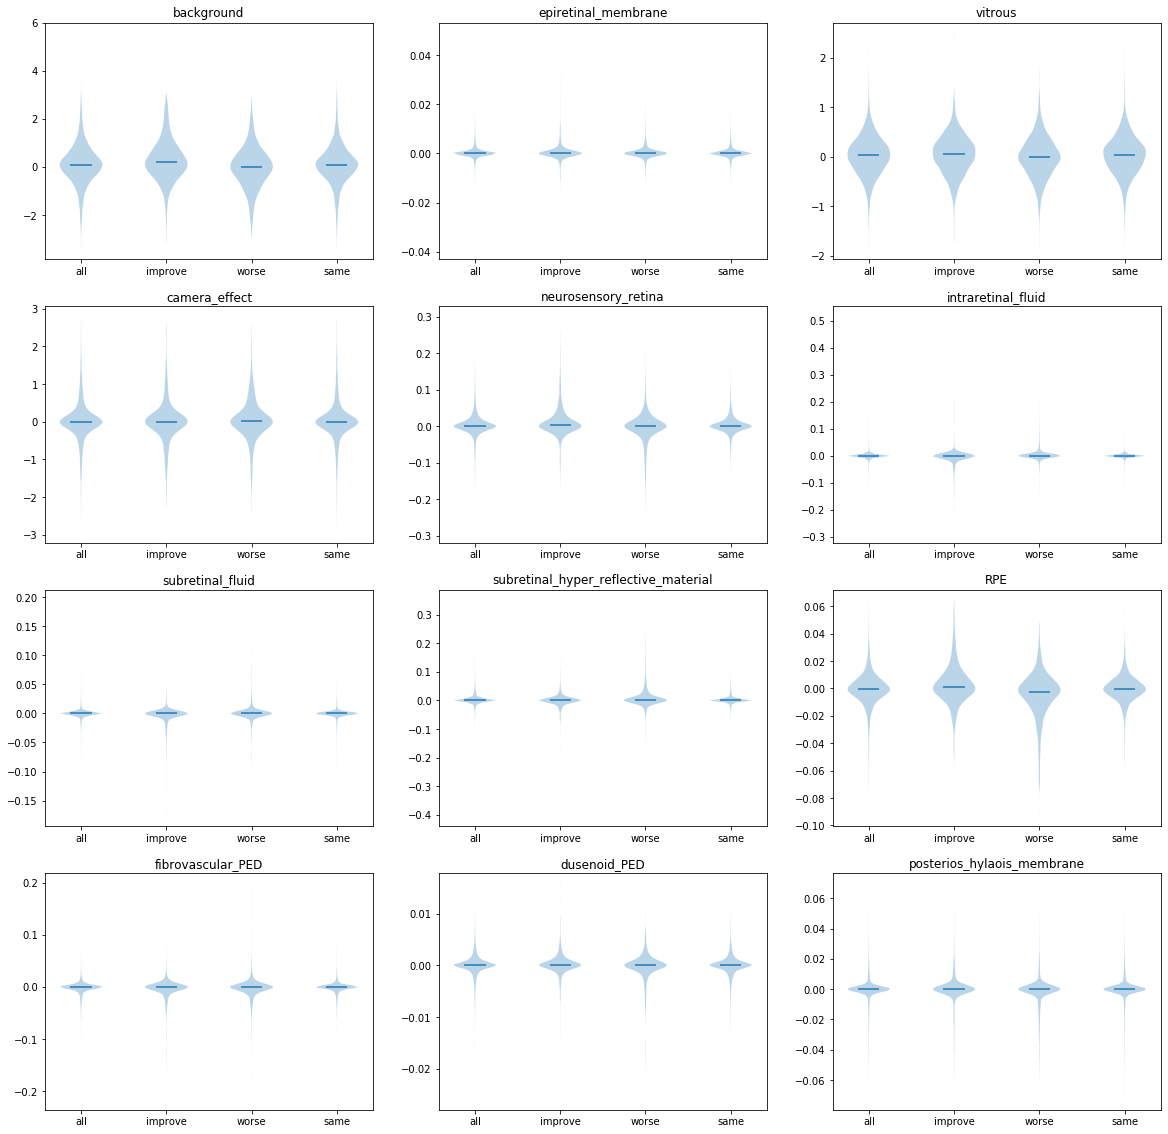

In [13]:
# plot difference in features vs labels
diff_features = checkup_features - features
fig, axes = plt.subplots(4,3, figsize=(20,20))
for i, ax in enumerate(axes.flat):

    ax.violinplot([diff_features[:,i], diff_features[labels==0,i], 
                   diff_features[labels==1,i], diff_features[labels==2,i]],
                 showmedians=True, showextrema=False)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['all', 'improve', 'worse', 'same'])
    ax.set_title(Measurement.FEATURES[i])

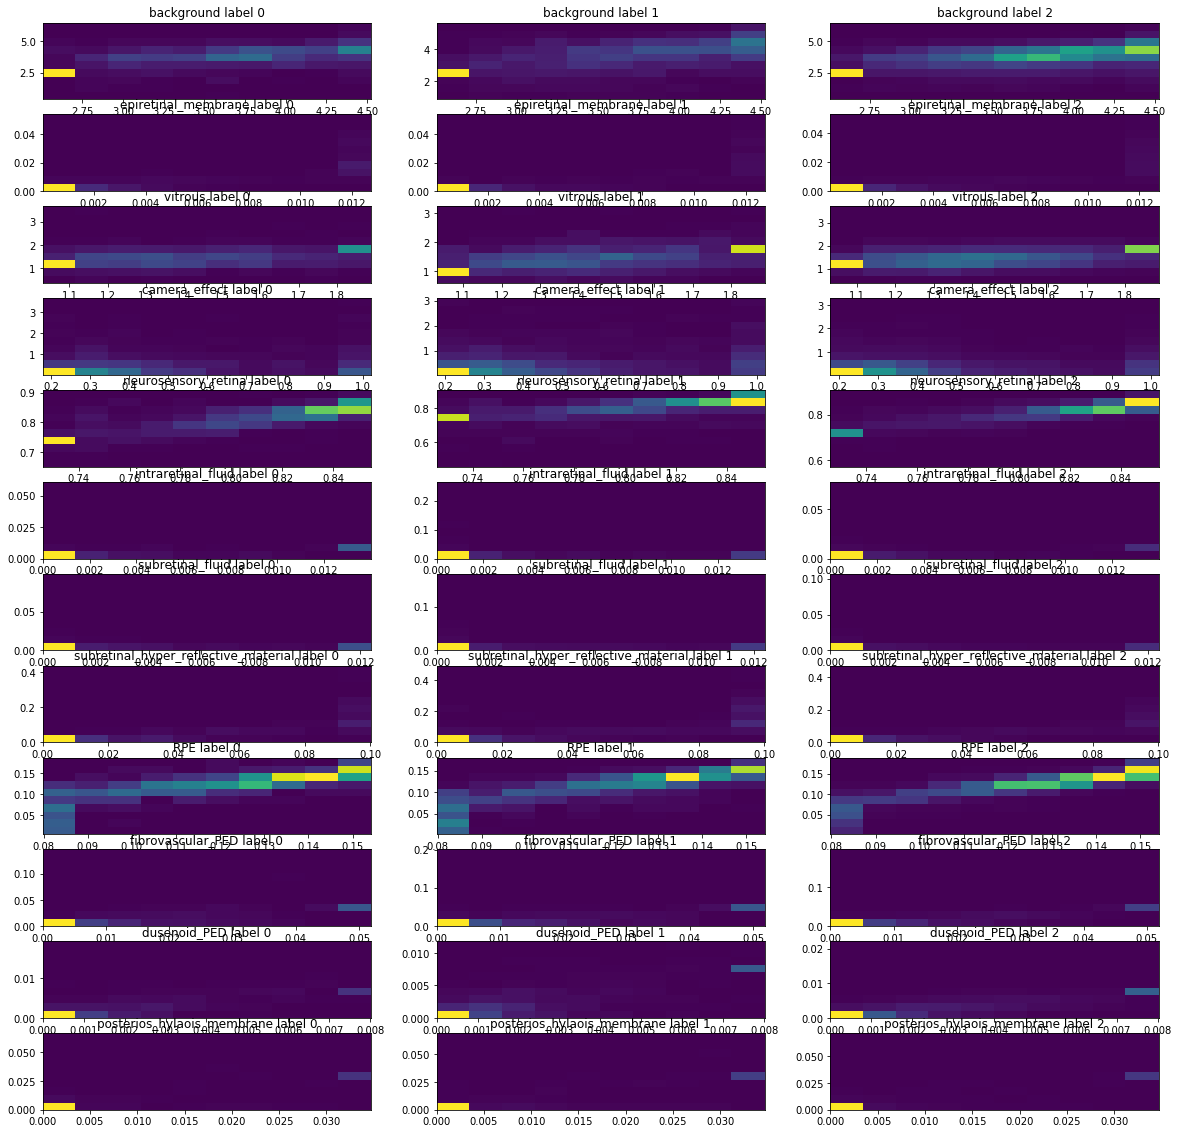

In [14]:
# plot checkup features vs last mmt features stratified for classes
# plot diff in features vs diff in va
# only plot for those records that have a big change in va
diff_features = checkup_features - features
diff_va = checkup_vas - vas

fig, axes = plt.subplots(12,3, figsize=(20,20))
for i, row in enumerate(axes):
    # restrict features to 0.1 and 0.9 quantile
    q01, q09 = np.quantile(features[:,i], (0.1,0.9))
    feat = features[:,i].copy()
    feat[feat < q01] = q01
    feat[feat > q09] = q09
    
    q01, q09 = np.quantile(checkup_features[:,i], (0.1,0.9))
    checkup_feat = checkup_features[:,i].copy()
    checkup_feat[feat < q01] = q01
    checkup_feat[feat > q09] = q09
    for l, ax in enumerate(row):
        ax.hist2d(feat[labels==l], checkup_feat[labels==l])
        ax.set_title('{} label {}'.format(Measurement.FEATURES[i], l))
    # data histogram
    #data, binx, biny = np.histogram2d(feat, diff_va[mask][:,0], bins=(10,np.arange(-1,1,0.1)))
    #data, binx, biny = np.histogram2d(feat, checkup_vas[mask][:,0], bins=(10,np.arange(0,2,0.1)))
    # normalize by va
    #data = data / data.sum(axis=0, keepdims=True)
    #data = data/ data.sum(axis=1, keepdims=True)
    #ax.pcolormesh(binx, biny, data.T)
    #ax.set_title(Measurement.FEATURES[i])

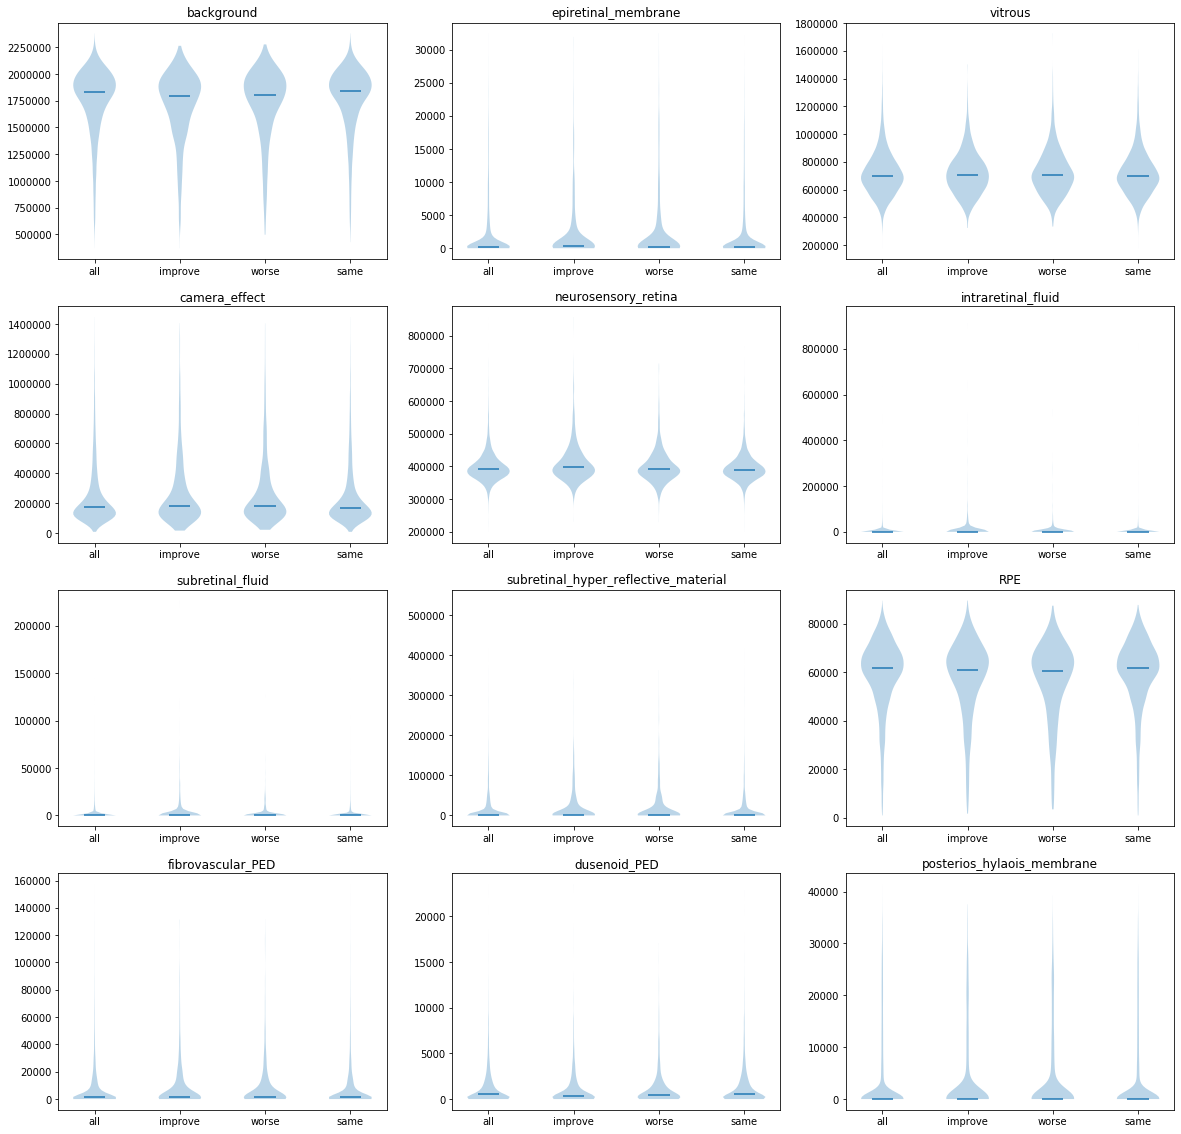

In [16]:
# plot feature distribution vs labels
fig, axes = plt.subplots(4,3, figsize=(20,20))
for i, ax in enumerate(axes.flat):

    ax.violinplot([features[:,i], features[labels==0,i], 
                   features[labels==1,i], features[labels==2,i]],
                 showmedians=True, showextrema=False)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['all', 'improve', 'worse', 'same'])
    ax.set_title(Measurement.FEATURES[i])

this does not really help; am mixing static and dynamic features (diff in va and current features).
- look at current/future va vs feature abundance (could stratify by all/improve/worse/same)
- look at diff in va vs diff in feature values

### correlations between features (+va) / diff features (+va) 

In [15]:
import scipy.stats 

In [25]:
# bin va in categories 
vas_categ = np.zeros_like(vas, dtype=np.uint8)
vas_categ[vas < 0.5] = 0
vas_categ[(vas >= 0.5) & (vas < 1.0)] = 1
vas_categ[vas >= 1.0] = 2

# normalize features - this is now done by default!
# calculate retinal pixels for each sample
#sum_retina = features[:,[1,4,5,6,7,8,9,10,11]].sum(axis=-1)
# normalize features by size of retina in each sample
#features_norm = features / sum_retina[:,np.newaxis]

#sum_retina = checkup_features[:,[1,4,5,6,7,8,9,10,11]].sum(axis=-1)
# normalize features by size of retina in each sample
#checkup_features_norm = checkup_features / sum_retina[:,np.newaxis]

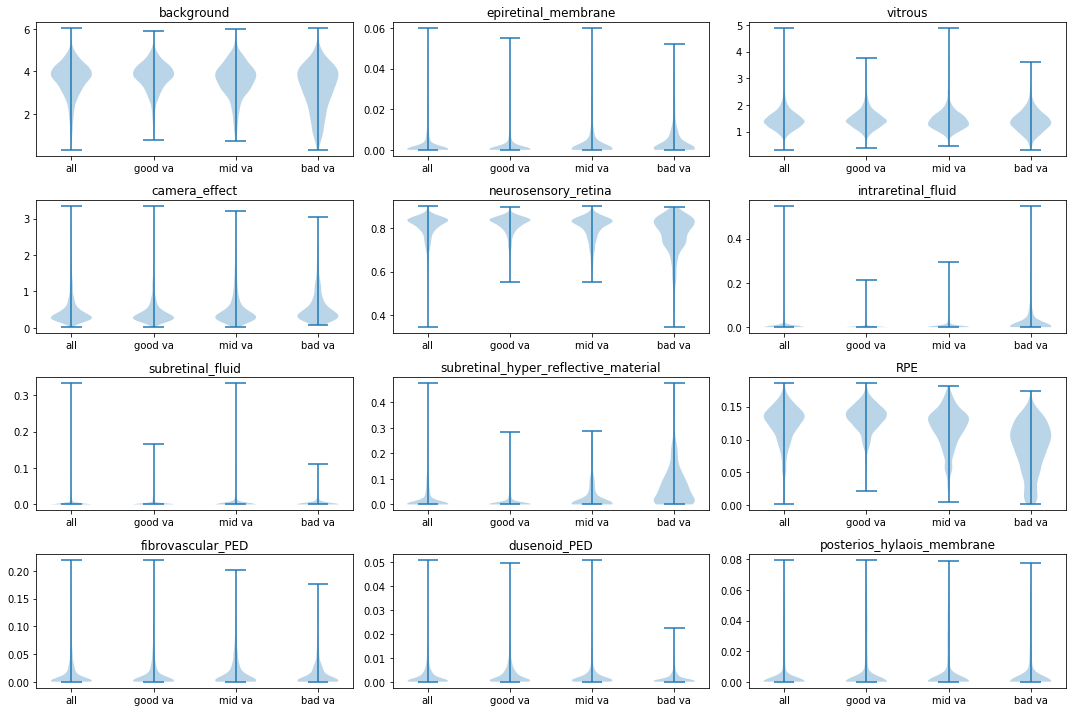

In [29]:
# plot distribution of relative amount of features in each sample
# also plot distribution for different va classes
fig, axes = plt.subplots(4,3, figsize=(15,10))
for i,ax in enumerate(axes.flat):
    ax.violinplot([features[:,i]] + [features[:,i][vas_categ[:,0]==c] for c in [0,1,2]])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['all', 'good va', 'mid va', 'bad va'])
    ax.set_title(Measurement.FEATURES[i])
plt.tight_layout()

distribution of features changes slightly for different va classes (especially RPE, neurosensory retina, subretinal_hyper_reflective_material)

Text(0.5, 1.0, 'Correlation between features + VA')

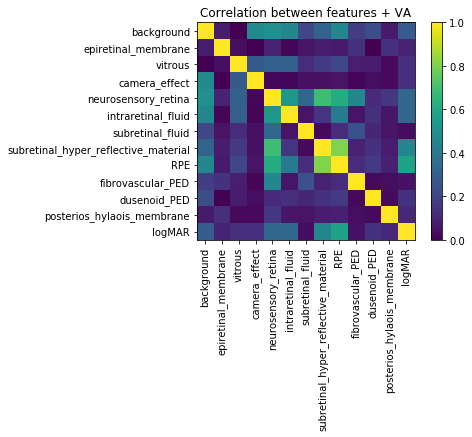

In [56]:
names = Measurement.FEATURES + ['logMAR']
values = np.concatenate([features_norm, vas], axis=-1)
values = values[labels!=2]

# calc correlation matrix
corr = np.zeros((len(names),len(names)))
p = np.zeros_like(corr)
for i in range(len(names)):
    for j in range(len(names)):
        corr[i,j], p[i,j] = scipy.stats.pearsonr(values[:,i], values[:,j])

fig, ax = plt.subplots(1,1)
im = ax.imshow(np.abs(corr), vmin=0, vmax=1)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.colorbar(im)
ax.set_title('Correlation between features + VA')

Text(0.5, 1.0, 'Correlation between  diff features + diff VA')

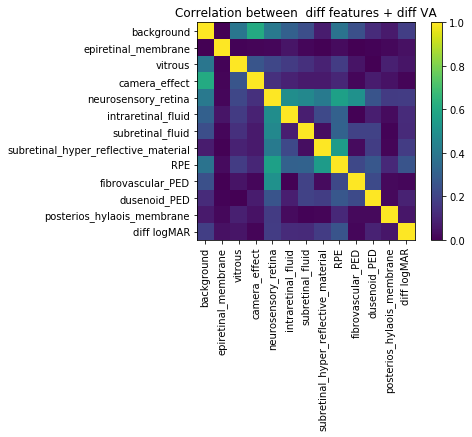

In [31]:
diff_features = checkup_features_norm - features_norm
diff_vas = checkup_vas - vas

names = Measurement.FEATURES + ['diff logMAR'] #, 'logMAR', 'prev va']
values = np.concatenate([diff_features, diff_vas], axis=-1)#, checkup_vas, vas], axis=-1)
values = values[labels!=2]  # restrict to only bigger changes

# calc correlation matrix
corr = np.zeros((len(names),len(names)))
p = np.zeros_like(corr)
for i in range(len(names)):
    for j in range(len(names)):
        corr[i,j], p[i,j] = scipy.stats.pearsonr(values[:,i], values[:,j])

fig, ax = plt.subplots(1,1)
im = ax.imshow(np.abs(corr), vmin=0, vmax=1)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.colorbar(im)
ax.set_title('Correlation between  diff features + diff VA')

no strong correlations between differences in features + VA, only strong correlation is between prev and current VA, slight correlation between diff VA + VA

## Decision Trees to classify 3 months difference based on current features + diff in features

In [19]:
io_vars = (IOVar.ALL_FEATURES, IOVar.CUR_VA, IOVar.CHECKUP2_ALL_FEATURES, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS)
train_dataset = LongitudinalOCTDataset(est.train_dataset.sequences, sequence_length=1, return_values=io_vars)
val_dataset = LongitudinalOCTDataset(est.val_dataset.sequences, sequence_length=1, return_values=io_vars)

In [20]:
def get_values_from_dataset(dataset):
    features = []
    vas = []
    checkup_features = []
    checkup_vas = []
    labels = []

    for feature, va, checkup_feature, checkup_va, label in dataset.dataset:
        features.append(feature.numpy()[0])
        checkup_features.append(checkup_feature.numpy()[0])
        vas.append(va.numpy()[0])
        checkup_vas.append(checkup_va.numpy()[0])
        labels.append(np.argmax(label.numpy()[0]))
    features = np.array(features)
    labels = np.array(labels)
    checkup_features = np.array(checkup_features)
    vas = np.array(vas)
    checkup_vas = np.array(checkup_vas)

    diff_features = checkup_features - features
    diff_vas = checkup_vas - vas
    
    return {'features': features, 'labels': labels, 'checkup_features': checkup_features, 'vas': vas,
           'checkup_vas': checkup_vas, 'diff_features': diff_features, 'diff_vas': diff_vas}


In [21]:
values_dict_train = get_values_from_dataset(train_dataset)
values_dict_val = get_values_from_dataset(val_dataset)

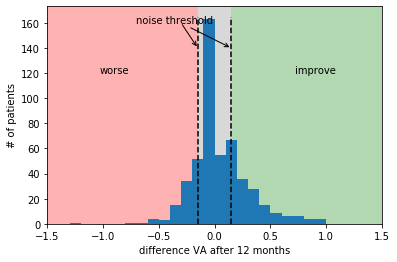

In [67]:
fig, ax = plt.subplots(1,1)
ax.axvspan(-1.5, -0.15, facecolor='red', alpha=0.3)
ax.axvspan(-0.15, 0.15, facecolor='gray', alpha=0.3)
ax.axvspan(0.15, 1.5, facecolor='green', alpha=0.3)
ax.text(-0.9,120,"worse",horizontalalignment='center')
ax.text(0.9,120,"improve",horizontalalignment='center')
ax.plot([-0.15, -0.15],[0,165], color='black', linestyle='--')
ax.plot([0.15, 0.15],[0,165], color='black', linestyle='--')
ax.annotate("noise threshold", xy=(0.15, 140), xytext=(-0.7, 160),
arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(-0.15, 140), xytext=(-0.3, 160),
arrowprops=dict(arrowstyle="->"))
ax.hist(values_dict_val['diff_vas'], bins=np.arange(-1.5,1.5,0.1))
ax.set_ylabel('# of patients')
ax.set_xlabel('difference VA after 12 months')
plt.xlim(-1.5,1.5)
plt.savefig('hist_deltaVA_12m.png', dpi=300)

0.3874833555259654


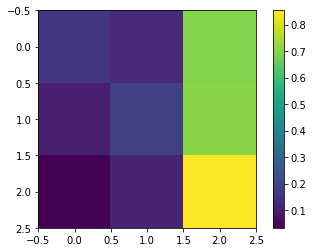

In [109]:
train_values = np.concatenate([values_dict_train['features'][:,[1,4,5,6,7,8,9,10,11]], 
                              values_dict_train['diff_features'][:,[1,4,5,6,7,8,9,10,11]],
                              values_dict_train['vas']
                              ], axis=-1)
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
clf.fit(train_values, values_dict_train['labels'])

val_values = np.concatenate([values_dict_val['features'][:,[1,4,5,6,7,8,9,10,11]], 
                              values_dict_val['diff_features'][:,[1,4,5,6,7,8,9,10,11]],
                              values_dict_val['vas']
                            ], axis=-1)
cnf_matrix = confusion_matrix(clf.predict(val_values), values_dict_val['labels'])
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cnf_matrix)
plt.colorbar()

print(f1_score(clf.predict(val_values), values_dict_val['labels'], average='micro'))

0.5969537107592631


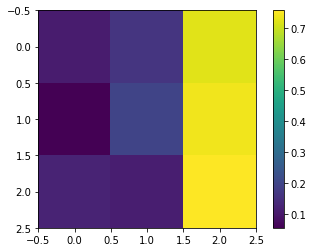

In [110]:
train_values = np.concatenate([values_dict_train['features'][:,[1,4,5,6,7,8,9,10,11]], 
                              values_dict_train['diff_features'][:,[1,4,5,6,7,8,9,10,11]],
                            #  values_dict_train['vas']
                              ], axis=-1)
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(train_values, values_dict_train['labels'])

val_values = np.concatenate([values_dict_val['features'][:,[1,4,5,6,7,8,9,10,11]], 
                              values_dict_val['diff_features'][:,[1,4,5,6,7,8,9,10,11]],
                            #  values_dict_val['vas']
                            ], axis=-1)
cnf_matrix = confusion_matrix(clf.predict(val_values), values_dict_val['labels'])
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cnf_matrix)
plt.colorbar()

print(f1_score(clf.predict(val_values), values_dict_val['labels'], average='weighted'))

similar (bad) performance for models with va and without va. 
Side question: For classification task, maybe current va is not very informative, need to have temporal data as well?

Overall:
does not perform well, need better features (temporal) / model (nn)

## Classify 3 month difference -- Models with different sequence lengths (1,2,3) 
train all on same data (delete shorter sequences, no 0-padding)
- use oversampling to avoid that assigns everything to "no change" class (oversample only during training, evaluation is done on imbalanced data)

In [4]:
res_dict = {}
for sl in [1,2,3]:
    cur_config = default_config
    cur_config['model']['sequence_length'] = sl
    #cur_config['model']['oversample_classification'] = False
    est = Estimator(cur_config)
    # only needed to avoid reloading sequences each time
    est.train_dataset, est.val_dataset, est.test_dataset = est.datasets_from_sequences(sequences_all)
    # train model
    history = est.train_model(verbose=0)
    # save results in dict
    res_dict[f'sl_{sl}'] = [history, est]

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_DIFF_VA_CLASS: 'checkup1_diff_va_class'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 3,
        "activation": "softmax",
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%

resulting norm values [None, None, None, None, None]


INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_DIFF_VA_CLASS: 'checkup1_diff_va_class'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 3,
        "activation": "softmax",
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading fe

resulting norm values [None, None, None, None, None]


INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_DIFF_VA_CLASS: 'checkup1_diff_va_class'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 3,
        "activation": "softmax",
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading fe

resulting norm values [None, None, None, None, None]


INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data
INFO:LongitudinalOCTDataset:oversampling data


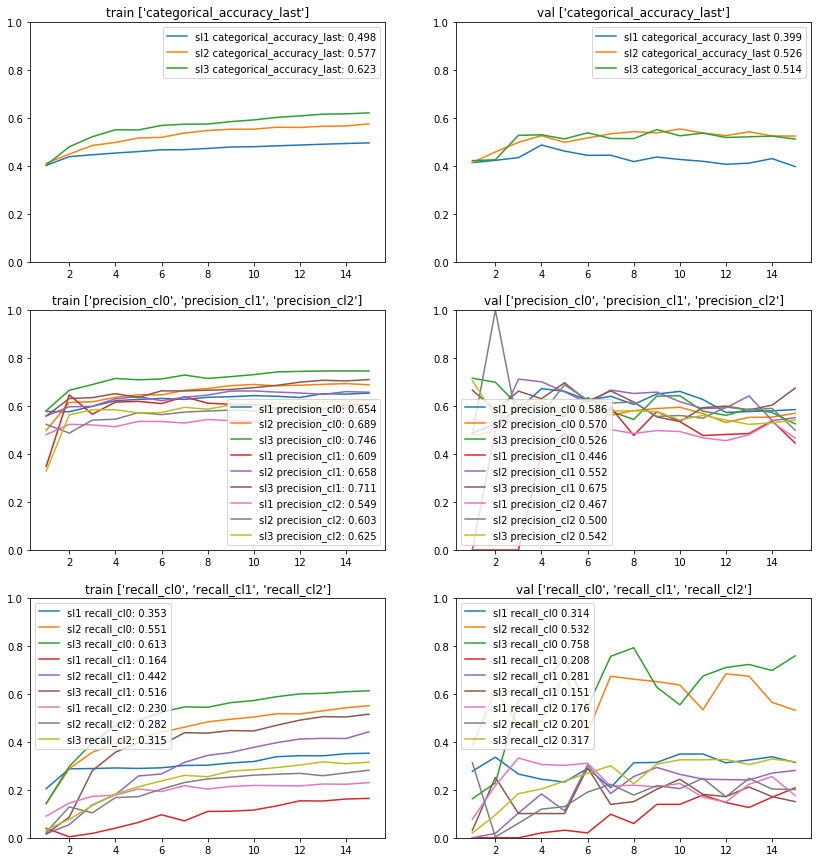

In [5]:
plot_history_comparison([res_dict['sl_1'][0], res_dict['sl_2'][0], res_dict['sl_3'][0]], ['sl1', 'sl2', 'sl3'], 
                        keys=['categorical_accuracy_last', 
                            ['precision_cl0', 'precision_cl1', 'precision_cl2'], 
                            ['recall_cl0', 'recall_cl1', 'recall_cl2']], ylim=(0,1))

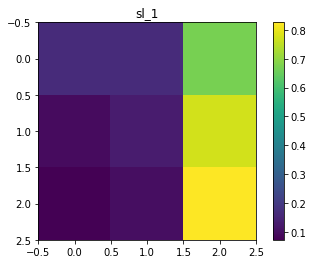

sl_1 0.2998066953551991


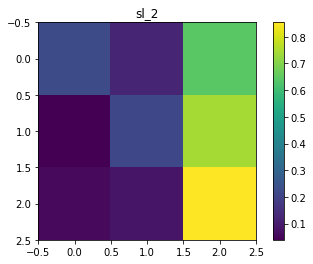

sl_2 0.4010542788443166


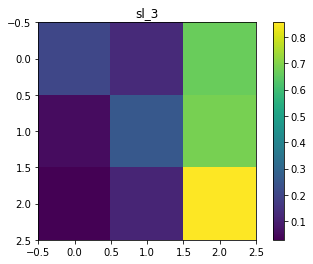

sl_3 0.39030608327062183


In [7]:
from sklearn.metrics import confusion_matrix, f1_score
for name, res in res_dict.items():
    est = res[1]
    # plot confusion matrix
    y_true = np.argmax(est.val_dataset.get_value_list([IOVar.CHECKUP1_DIFF_VA_CLASS])[0], axis=-1)[:,-1]
    y_pred = np.argmax(est.predict_model(), axis=-1)[:,-1]

    cnf_matrix = confusion_matrix(y_pred, y_true)
    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix)
    plt.colorbar()
    plt.title(name)
    plt.show()
    print(name, f1_score(y_pred, y_true, average='macro'))


- nn uses data better than decision tree, for longer sequence lengths, performs better
- sequences of length 2 and 3 perform similarly - but this context is important!
- oversampling worked a bit better (after lots of bugs were fixed!), all classes are recognized. Otherwise was prone to missing entire labels
- TODO: train decision tree on data for longer sequences as well!

Conclusion: classification is possible, but difficult, there are ~50% missed cases for each difficuls class (large change in VA). Would be interesting to look as these cases, but first should try to perform even better. Maybe with an LSTM?

In [7]:
# train model without current va on sequence length 2
cur_config = default_config
cur_config['model']['sequence_length'] = 2
cur_config['model']['input_vars'] = [IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES]
est = Estimator(cur_config)
# only needed to avoid reloading sequences each time
est.train_dataset, est.val_dataset, est.test_dataset = est.datasets_from_sequences(sequences_all)
# train model
history = est.train_model(verbose=1)

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_DIFF_VA_CLASS: 'checkup1_diff_va_class'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 3,
        "activation": "softmax",
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 11152/11152 [

resulting norm values [None, None, None, None, None]
numclasses 3


INFO:LongitudinalOCTDataset:oversampling data


numclasses 3


INFO:LongitudinalOCTDataset:oversampling data


numclasses 3
Epoch 1/15
31/31 [==============================] - 10s 331ms/step - loss: 1.1245 - categorical_accuracy_last: 0.3384 - precision_cl0: 0.3274 - recall_cl0: 0.0541 - precision_cl1: 0.3657 - recall_cl1: 0.0095 - precision_cl2: 0.3373 - recall_cl2: 0.0337 - val_loss: 1.1003 - val_categorical_accuracy_last: 0.3688 - val_precision_cl0: 0.0000e+00 - val_recall_cl0: 0.0000e+00 - val_precision_cl1: 0.0000e+00 - val_recall_cl1: 0.0000e+00 - val_precision_cl2: 0.0000e+00 - val_recall_cl2: 0.0000e+00
Epoch 2/15
31/31 [==============================] - 9s 296ms/step - loss: 1.0901 - categorical_accuracy_last: 0.3715 - precision_cl0: 1.0000 - recall_cl0: 3.9085e-04 - precision_cl1: 0.4889 - recall_cl1: 0.0128 - precision_cl2: 0.0000e+00 - recall_cl2: 0.0000e+00 - val_loss: 1.1053 - val_categorical_accuracy_last: 0.3611 - val_precision_cl0: 0.0000e+00 - val_recall_cl0: 0.0000e+00 - val_precision_cl1: 0.5357 - val_recall_cl1: 0.0266 - val_precision_cl2: 0.0000e+00 - val_recall_cl2: 0.000

In [8]:
# make sure that oversampling worked
classes = []
for el in est.train_dataset.dataset_for_training.batch(200):
    classes.append(el[-1])
    
labels = []
for cl in classes:
    labels.extend(list(np.argmax(cl[0].numpy(), axis=-1)[:,-1]))
    
print(sum(np.array(labels)==0))
print(sum(np.array(labels)==1))
print(sum(np.array(labels)==2))

5117
5138
5111


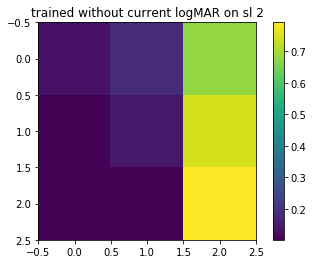

trained without logMAR 0.3356612254972744


In [11]:
# plot confusion matrix
y_true = np.argmax(est.val_dataset.get_value_list([IOVar.CHECKUP1_DIFF_VA_CLASS])[0], axis=-1)[:,-1]
y_pred = np.argmax(est.predict_model(), axis=-1)[:,-1]

cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.imshow(cnf_matrix)
plt.colorbar()
plt.title('trained without current logMAR on sl 2')
plt.show()
print('trained without logMAR', f1_score(y_pred, y_true, average='macro'))

training without logMAR does not work well, needs logMAR information to predict change (logMAR is moderately correlated with change in logMAR)